#### This file contains : Simple CNN model experiment, Basic CNN model Net(), NetDropout(), and NetBatchnorm(). Finding learning rate. Plot results

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "./"

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import math
import h5py
import time
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
data_hdf5_root = os.path.join(path, "data/asl/data.hdf5")

In [ ]:
random_seed = 123 # set random seed for reproductivity
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#### Simple Model Data Prepare

In [ ]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, name, transform=None):
        super().__init__
        self.file_path = file_path
        self.data_cache = {}
        self.transform = transform
        self.name = str(name)
        self.name_label = str(name) + "_label"
        self.size = None
        with h5py.File(file_path, 'r') as hf:
            self.data_cache[self.name] = hf[self.name][:]
            self.data_cache[self.name_label] = hf[self.name_label][:]
            self.size = len(hf[self.name_label])

    def __getitem__(self, index):
        img = self.data_cache[self.name][index]
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)

        label = self.data_cache[self.name_label][index]
        return img, label

    def __len__(self):
        return self.size

In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5190, 0.4993, 0.5141),
                                                         (0.2280, 0.2555, 0.2637))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5190, 0.4993, 0.5141),
                                                         (0.2280, 0.2555, 0.2637))])

In [ ]:
train_dataset = HDF5Dataset(data_hdf5_root, name = "train", transform = train_transforms)
val_dataset = HDF5Dataset(data_hdf5_root, name = "val", transform = test_transforms)

print(f"train size is {len(train_dataset)}")
print(f"validation size is {len(val_dataset)}")
print(f"All data size is {len(train_dataset)+len(val_dataset)}")

train size is 69600
validation size is 17400
All data size is 87000


#### Three Models

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(25 * 25 * 8, 128)
        self.fc2 = nn.Linear(128, 29)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(out.shape[0], -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv1_dropout = nn.Dropout2d(p=p)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=p)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv3_dropout = nn.Dropout2d(p=p)
        self.fc1 = nn.Linear(25 * 25 * 8, 128)
        self.fc2 = nn.Linear(128, 29)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = self.conv3_dropout(out)
        out = out.view(out.shape[0], -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv3_batchnorm = nn.BatchNorm2d(num_features=8)
        self.fc1 = nn.Linear(25 * 25 * 8, 128)
        self.fc2 = nn.Linear(128, 29)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.conv3_batchnorm(self.conv3(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(out.shape[0], -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### Finding Learning Rate

In [ ]:
def find_lr(train_loader, model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for imgs, labels in train_loader:
      batch_num += 1
      imgs, labels = imgs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      # Crash out if loss explodes
      if batch_num > 1 and loss > 4 * best_loss:
          return log_lrs[10:-5], losses[10:-5]
      # Record the best loss
      if loss < best_loss or batch_num == 1:
          best_loss = loss
      # Store the values
      losses.append(loss.item())
      log_lrs.append(math.log10(lr))
      # Do the backward pass and optimize
      loss.backward()
      optimizer.step()
      # Update the lr for the next step and store
      lr *= update_step
      optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

In [ ]:
batch_size = 128

model = Net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr = 0)

model_dropout1 = NetDropout(p=0.3).to(device=device)
optimizer_dropout1 = optim.Adam(model_dropout1.parameters(), lr = 0)

model_dropout2 = NetDropout(p=0.4).to(device=device)
optimizer_dropout2 = optim.Adam(model_dropout2.parameters(), lr = 0)

model_batchnorm = NetBatchNorm().to(device=device)
optimizer_batchnorm = optim.Adam(model_batchnorm.parameters(), lr = 0)
 
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
logs, losses = find_lr(train_loader, model, loss_fn, optimizer)
logs_dropout1, losses_dropout1 = find_lr(train_loader, model_dropout1, loss_fn, optimizer_dropout1)
logs_dropout2, losses_dropout2 = find_lr(train_loader, model_dropout2, loss_fn, optimizer_dropout2)
logs_batchnorm, losses_batchnorm = find_lr(train_loader, model_batchnorm, loss_fn, optimizer_batchnorm)

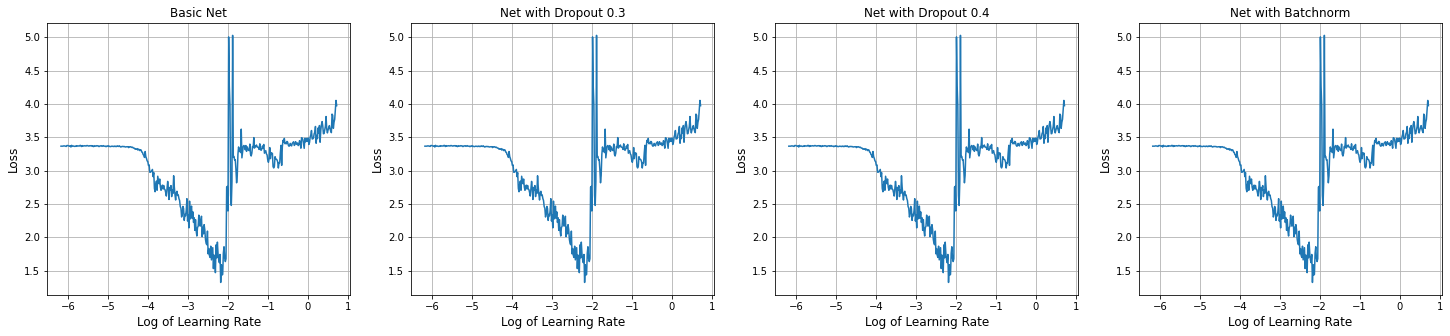

In [ ]:
# plot loss against log of learning rate to find the best learning rate
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
titles = ["Basic Net", "Net with Dropout 0.3", "Net with Dropout 0.4", "Net with Batchnorm"]
for i, title in enumerate(titles):
  axs[i].grid()
  axs[i].set_title(title)
  axs[i].plot(logs[100:], losses[100:])
  axs[i].set_xlabel('Log of Learning Rate', size='large')
  axs[i].set_ylabel('Loss', size='large')


#### Finding Learning Rate 10**(-2.5) for Adam, use it to train

In [ ]:
def train_loop(n_epochs, train_loader, val_loader, model, loss_fn, optimizer):
    loss_train_list = []
    acc_train_list = []
    loss_val_list = []
    acc_val_list = []
    acc_val_max = 0
    n_stop = 0
    for epoch in range(1, n_epochs+1):
        model.train()
        loss_train = 0.0
        correct = 0
        total = 0
        start_time = time.time()
        print(f"Epoch {epoch} Training start:")
        for batch_i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            loss_train += loss.item()
            if (batch_i) % 200 == 0:
                print ('Epoch {}, Step {}, Loss: {:.4f}'
                .format(epoch, batch_i, loss.item()))
                #torch.save(model.state_dict(), path_store_net)
        
        loss_train_list.append(loss_train/len(train_loader))
        acc_train_list.append(100 * correct/total)
        end_time = time.time()
        print('Duration: {:.2} minutes, Epoch {}, Training loss {:.4f}, Training accuracy {:2.3f}%'
        .format((end_time - start_time)/60 ,epoch,
            loss_train/len(train_loader), 100*correct/total))

        # validation
        loss_val = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                loss = loss_fn(outputs, labels)
                loss_val += loss.item()

            acc_val = 100*correct/total
            loss_val_list.append(loss_val/len(val_loader))#loss per batch
            acc_val_list.append(acc_val)
            print('Epoch {}, Validation loss {:.4f}, Validation accuracy {:2.3f}%'
            .format(epoch, loss_val/len(val_loader), acc_val))
        
            if acc_val > acc_val_max:
                acc_val_max = acc_val
                #torch.save(model.state_dict(), path+'resnet_simple_model.pt')
                print('Detect Improvement')
            else:
                n_stop += 1
    
        if(n_stop == 2):
            break
    return (loss_train_list, acc_train_list, loss_val_list, acc_val_list)

In [ ]:
batch_size = 128
n_epochs = 20

model = Net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr = 10**(-2.5))

model_dropout1 = NetDropout(p=0.3).to(device=device)
optimizer_dropout1 = optim.Adam(model_dropout1.parameters(), lr = 10**(-2.5))

model_dropout2 = NetDropout(p=0.4).to(device=device)
optimizer_dropout2 = optim.Adam(model_dropout2.parameters(), lr = 10**(-2.5))

model_batchnorm = NetBatchNorm().to(device=device)
optimizer_batchnorm = optim.Adam(model_batchnorm.parameters(), lr = 10**(-2.5))
 
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

"Basic Net" : 
<br>
Duration: 1.7 minutes, Epoch 7, Training loss 0.0322, Training accuracy 98.978%
<br>
Epoch 7, Validation loss 0.0605, Validation accuracy 98.132%

"Net with Dropout 0.3": 
<br>
Epoch 10, Training loss 0.1911, Training accuracy 93.967%
<br>
Epoch 10, Validation loss 0.0729, Validation accuracy 97.500%

"Net with Dropout 0.4": 
<br>
Epoch 11, Training loss 0.2333, Training accuracy 92.938%
<br>
Epoch 11, Validation loss 0.0741, Validation accuracy 97.368%

"Net with Batchnorm": 
<br>
Epoch 7, Training loss 0.0791, Training accuracy 97.244%
<br>
Epoch 7, Validation loss 0.1055, Validation accuracy 96.126%

In [ ]:
titles = ["Basic Net", "Net with Dropout 0.3", "Net with Dropout 0.4", "Net with Batchnorm"]
print(titles[0])
res = train_loop(n_epochs, train_loader, val_loader, model, loss_fn, optimizer)
print(titles[1])
res_dropout1 = train_loop(n_epochs, train_loader, val_loader, model_dropout1, loss_fn, optimizer_dropout1)
print(titles[2])
res_dropout2 = train_loop(n_epochs, train_loader, val_loader, model_dropout2, loss_fn, optimizer_dropout2)
print(titles[3])
res_batchnorm = train_loop(n_epochs, train_loader, val_loader, model_batchnorm, loss_fn, optimizer_batchnorm)

Epoch 1 Training start:
Epoch 1, Step 0, Loss: 3.3663
Epoch 1, Step 200, Loss: 0.6667
Epoch 1, Step 400, Loss: 0.3219
Duration: 1.8 minutes, Epoch 1, Training loss 0.8265, Training accuracy 74.741%
Epoch 1, Validation loss 0.2725, Validation accuracy 91.029%
Detect Improvement
Epoch 2 Training start:
Epoch 2, Step 0, Loss: 0.1864
Epoch 2, Step 200, Loss: 0.1330
Epoch 2, Step 400, Loss: 0.1521
Duration: 1.7 minutes, Epoch 2, Training loss 0.1241, Training accuracy 95.904%
Epoch 2, Validation loss 0.1013, Validation accuracy 96.649%
Detect Improvement
Epoch 3 Training start:
Epoch 3, Step 0, Loss: 0.0613
Epoch 3, Step 200, Loss: 0.0344
Epoch 3, Step 400, Loss: 0.0213
Duration: 1.7 minutes, Epoch 3, Training loss 0.0664, Training accuracy 97.714%
Epoch 3, Validation loss 0.0722, Validation accuracy 97.661%
Detect Improvement
Epoch 4 Training start:
Epoch 4, Step 0, Loss: 0.0766
Epoch 4, Step 200, Loss: 0.0430
Epoch 4, Step 400, Loss: 0.0441
Duration: 1.7 minutes, Epoch 4, Training loss 0.

#### Plot loss and accuracy

In [ ]:
loss_train_lists = [] 
acc_train_lists = [] 
loss_val_lists = [] 
acc_val_lists = []
for r in [res, res_dropout1, res_dropout2, res_batchnorm]:
  loss_train_lists.append(r[0])
  acc_train_lists.append(r[1])
  loss_val_lists.append(r[2])
  acc_val_lists.append(r[3])

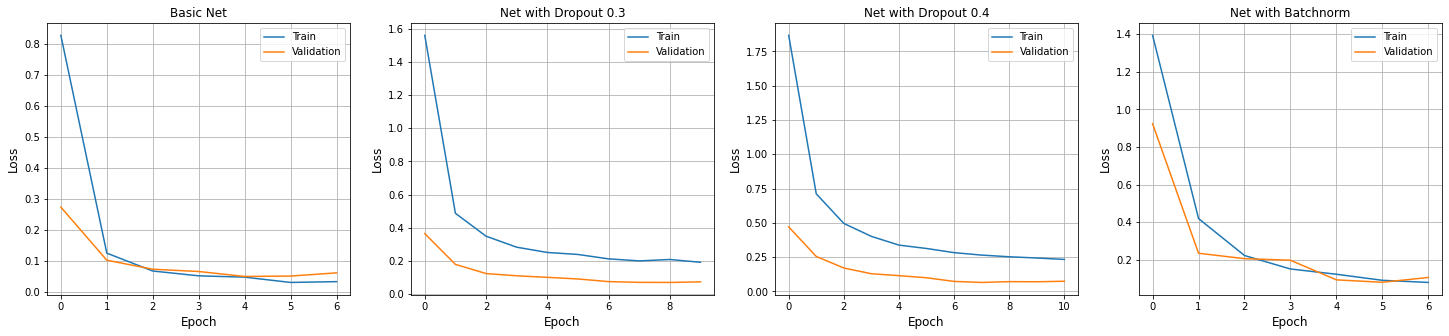

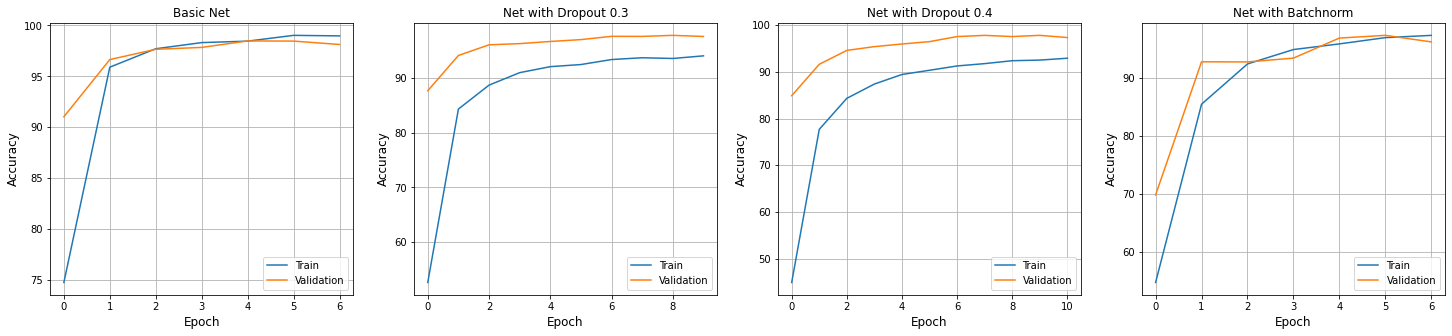

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(25, 5))
titles = ["Basic Net", "Net with Dropout 0.3", "Net with Dropout 0.4", "Net with Batchnorm"]
# plot loss
for i, title in enumerate(titles):
  trainl = loss_train_lists[i]
  vall = loss_val_lists[i]
  n = range(len(trainl))
  axs[i].grid()
  axs[i].set_title(title)
  axs[i].plot(n, trainl, label="Train")
  axs[i].plot(n, vall, label="Validation")
  axs[i].set_xlabel('Epoch', size='large')
  axs[i].set_ylabel('Loss', size='large')
  axs[i].legend(loc='upper right')

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
# plot accuracy
for i, title in enumerate(titles):
  traina = acc_train_lists[i]
  vala = acc_val_lists[i]
  n = range(len(traina))
  axs[i].grid()
  axs[i].set_title(title)
  axs[i].plot(n, traina, label="Train")
  axs[i].plot(n, vala, label="Validation")
  axs[i].set_xlabel('Epoch', size='large')
  axs[i].set_ylabel('Accuracy', size='large')
  axs[i].legend(loc='lower right')

#### Test!

In [ ]:
def test_loop(test_loader, model, loss_fn):
    loss_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            loss = loss_fn(outputs, labels)
            loss_total += loss.item()

        acc_test = 100*correct/total
    print('Total loss {:.4f}, Total accuracy {:2.3f}%'
            .format(loss_total/len(test_loader), acc_test))
    return acc_test, correct

In [ ]:
test_dataset = HDF5Dataset(data_hdf5_root, name="test", transform = test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [ ]:
acc_test, cn = test_loop(test_loader, model, loss_fn)
acc_test_dropout1, cn_dropout1 = test_loop(test_loader, model_dropout1, loss_fn)
acc_test_dropout2, cn_dropout2 = test_loop(test_loader, model_dropout2, loss_fn)
acc_test_batchnorm, cn_batchnorm = test_loop(test_loader, model_batchnorm, loss_fn)
print("Test Data:")
print(f"original CNN accuracy : {acc_test :2.3f}, correct number : {cn}/{len(test_dataset)}")
print(f"CNN dropout1 accuracy : {acc_test_dropout1 :2.3f}, correct number : {cn_dropout1}/{len(test_dataset)}")
print(f"CNN dropout2 accuracy : {acc_test_dropout2 :2.3f}, correct number : {cn_dropout2}/{len(test_dataset)}")
print(f"CNN batchnorm accuracy : {acc_test_batchnorm :2.3f}, correct number : {cn_batchnorm}/{len(test_dataset)}")

Total loss 0.0146, Total accuracy 100.000%
Total loss 0.0003, Total accuracy 100.000%
Total loss 0.0056, Total accuracy 100.000%
Total loss 0.0513, Total accuracy 96.552%
Test Data:
original CNN accuracy : 100.000, correct number : 29/29
CNN dropout1 accuracy : 100.000, correct number : 29/29
CNN dropout2 accuracy : 100.000, correct number : 29/29
CNN batchnorm accuracy : 96.552, correct number : 28/29


In [ ]:
test2_dataset = HDF5Dataset(data_hdf5_root, name="test2", transform = test_transforms)
test2_loader = DataLoader(test2_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [ ]:
acc_test2, cn2= test_loop(test2_loader, model, loss_fn)
acc_test2_dropout1, cn2_dropout1= test_loop(test2_loader, model_dropout1, loss_fn)
acc_test2_dropout2, cn2_dropout2= test_loop(test2_loader, model_dropout2, loss_fn)
acc_test2_batchnorm, cn2_batchnorm= test_loop(test2_loader, model_batchnorm, loss_fn)
print("Test2 Data:")
print(f"original CNN accuracy : {acc_test2 :2.3f}, correct number : {cn2}/{len(test2_dataset)}")
print(f"CNN dropout accuracy1 : {acc_test2_dropout1 :2.3f}, correct number : {cn2_dropout1}/{len(test2_dataset)}")
print(f"CNN dropout accuracy2 : {acc_test2_dropout2 :2.3f}, correct number : {cn2_dropout2}/{len(test2_dataset)}")
print(f"CNN batchnorm accuracy : {acc_test2_batchnorm :2.3f}, correct number : {cn2_batchnorm}/{len(test2_dataset)}")

Total loss 62.4346, Total accuracy 4.919%
Total loss 31.1529, Total accuracy 3.183%
Total loss 18.1271, Total accuracy 4.456%
Total loss 71.7915, Total accuracy 5.845%
Test2 Data:
original CNN accuracy : 4.919, correct number : 85/1728
CNN dropout accuracy1 : 3.183, correct number : 55/1728
CNN dropout accuracy2 : 4.456, correct number : 77/1728
CNN batchnorm accuracy : 5.845, correct number : 101/1728
